# Carga de archivos y bibliotecas

In [23]:
!rm -rf data
!rm -rf regresion
!rm -rf utilidades
!wget https://github.com/rodrigofvc/prediccion-temp-mexico/archive/refs/heads/main.zip

import zipfile

with zipfile.ZipFile("main.zip","r") as zip_ref:
  zip_ref.extractall(".")

!cp -rf "./prediccion-temp-mexico-main/data" "."
!cp -rf "./prediccion-temp-mexico-main/regresion" "."
!cp -rf "./prediccion-temp-mexico-main/utilidades" "."
!rm -rf "prediccion-temp-mexico-main"
!rm -rf "sample_data"
!rm "main.zip"

--2022-11-28 10:08:54--  https://github.com/rodrigofvc/prediccion-temp-mexico/archive/refs/heads/main.zip
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/rodrigofvc/prediccion-temp-mexico/zip/refs/heads/main [following]
--2022-11-28 10:08:54--  https://codeload.github.com/rodrigofvc/prediccion-temp-mexico/zip/refs/heads/main
Resolving codeload.github.com (codeload.github.com)... 140.82.114.9
Connecting to codeload.github.com (codeload.github.com)|140.82.114.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘main.zip’

main.zip                [  <=>               ] 760.50M  17.0MB/s    in 39s     

2022-11-28 10:09:37 (19.5 MB/s) - ‘main.zip’ saved [797437106]



In [24]:
!pip install pytorch-lightning
from utilidades.Lector_Futuro import Lector_Futuro
from utilidades.Lector import Lector
import sys

# Utilerias
import os
import math
import random
import datetime

# Matrices y DataFrame
import numpy as np
import pandas as pd

# Lightning
from pytorch_lightning import seed_everything
import pytorch_lightning as pl
import torch.nn.functional as F
from torchvision import datasets, transforms
from pytorch_lightning.loggers import TensorBoardLogger
from torchmetrics import MeanAbsoluteError

# Redes neuronales
import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.dates as mdates

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [25]:
SEED = 99
def set_seed(seed):
    """Initializes pseudo-random number generators."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
set_seed(SEED)

In [26]:
from sklearn.preprocessing import MinMaxScaler

def obtenerDS(hora, rutaArchivo):
  # Lee los datos del directorio
  l = Lector_Futuro(rutaArchivo)
  X, Y = l.get_data(hora, pasosPasado=1, pasosFuturo=1, excluirColumnasX=['Direcci�n del Viento (grados)', 'Direcci�n de r�faga (grados)'], agregarHoraLocalY=True, show=True)
  # El conjunto de datos se filtra a un intervalo especifico
  #lp = Lector(rutaArchivo)
  #fecha_cercana = "2022-11-27 " + hora
  #fecha_lejana = "2022-11-22 " + hora
  #X_out, Y_out = lp.intervalo(X, Y, fecha_cercana, fecha_lejana)
  #X = X_out
  #Y = Y_out

  # Min Max scaler se entrena con X de entrenamiento
  scaler = MinMaxScaler()
  scaler.fit(X)

  # Se escalan ambos X (entrenamiento y prueba) con el scaler previamente
  X_scaled = scaler.transform(X)
  
  return X_scaled, Y

In [27]:
def graficar(Y, predictions_list, hora):
  # Muestra la grafica con las predicciones de dias futuros
  fig1 = plt.figure()
  axs1 = fig1.add_subplot(1, 1, 1)
  axs1.set_xlabel("Fecha (YYYY-MM-DD)")
  axs1.set_ylabel("Temperatura (°C)")
  axs1.plot(Y['Hora Local'].to_numpy(),Y['Temperatura del Aire (�C) t'].to_list(), '-o', label='Temperatura real')
  axs1.plot(Y['Hora Local'].to_numpy(),predictions_list, '-o', label='Temperatura predecida')
  axs1.legend(loc="upper left")
  axs1.set_title(f'Prediccion temperatura {hora} (1 dia a futuro)')
  fig1.set_size_inches(8,4)
  plt.grid()
  plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
  #plt.gca().tick_params(axis='x', labelrotation=45)
  fig1.savefig('pred.png')
  from google.colab import files
  files.download("pred.png")

In [28]:
from torch.nn.modules.activation import LeakyReLU
class MLP(pl.LightningModule):

  def __init__(self, numEntradas, neuronasOcultas=[100,100], lr=0.000001):
    # Se llama al inicializador de la clase padre
    super(MLP, self).__init__()

    # Se define el numero de entradas y salidas del modelo
    self.numEntradas = numEntradas
    self.numSalidas = 1
    self.neuronasOcultas = neuronasOcultas

    # Se define la tasa de aprendizaje
    self.lr = lr

    # Se define la arquitectura del modelo
    self.fc1 = nn.Linear(self.numEntradas, self.neuronasOcultas[0])
    self.fc2 = nn.Linear(self.neuronasOcultas[0], self.neuronasOcultas[1])
    self.out = nn.Linear(self.neuronasOcultas[1], self.numSalidas)
          
    # Se define la función de pérdida para entrenamiento
    self.loss = nn.MSELoss()
    
  def forward(self, x):
    # Se define la función forward (hacia adelante) del modelo
    if(type(x) is list):
      x = x[0]

    x = self.fc1(x)
    x = F.leaky_relu(x)
    x = self.fc2(x)
    x = F.leaky_relu(x)
    x = self.out(x)
    return x

  def configure_optimizers(self):
    # Se define como optimizador el descenso por gradiente estocástico (con momento)
    return torch.optim.Adam(self.parameters(), lr = self.lr)

  # Se definen los pasos de entrenamiento del modelo
  def training_step(self, train_batch, batch_idx):
    # Se obtienen los datos del lote
    x, y = train_batch
    # Se hace inferencia para obtener los logits
    logits = self.forward(x)
    # Se calcula la pérdida con los datos de entrenamiento
    loss = self.loss(logits, y)
    MAE_obj = MeanAbsoluteError()
    MAE_loss = MAE_obj(logits, y)#nn.L1Loss(logits, y)#(y - logits).abs().mean()
    RMSE_loss = torch.sqrt(loss)#(y - logits).abs().mean()

    output={
      "loss": loss,
      "MAE_loss": MAE_loss,
      "RMSE_loss": RMSE_loss
    }

    # Retorna la pérdida del lote
    return output

  # Se definen los pasos de validación del modelo
  def validation_step(self, valid_batch, batch_idx):
    # Se obtienen los datos del lote
    x, y = valid_batch
    # Se hace inferencia para obtener los logits
    logits = self.forward(x)
    #Se calcula la pérdida con los datos de validación
    loss = self.loss(logits, y)
    MAE_obj = MeanAbsoluteError()
    MAE_loss = MAE_obj(logits, y)#nn.L1Loss(logits, y)#(y - logits).abs().mean()
    RMSE_loss = torch.sqrt(loss)#(y - logits).abs().mean()

    output={
      "loss": loss,
      "MAE_loss": MAE_loss,
      "RMSE_loss": RMSE_loss
    }

    # Retorna la pérdida del lote
    return output

  # Esta función se llama cuando cada época de entrenamiento termina
  def training_epoch_end(self, outputs):

    # Se calcula el promedio de todos los lotes en la época
    avg_loss_trn = torch.stack([x['loss'] for x in outputs]).mean()
    avg_MAE_loss_trn = torch.stack([x['MAE_loss'] for x in outputs]).mean()
    avg_RMSE_loss_trn = torch.stack([x['RMSE_loss'] for x in outputs]).mean()

    # Se manda graficar a TensorBoard
    self.logger.experiment.add_scalar("Pérdida/MSE Entrenamiento",
                                      avg_loss_trn,
                                      self.current_epoch)
    self.logger.experiment.add_scalar("Pérdida/MAE Entrenamiento",
                                      avg_MAE_loss_trn,
                                      self.current_epoch)
    self.logger.experiment.add_scalar("Pérdida/RMSE Entrenamiento",
                                      avg_RMSE_loss_trn,
                                      self.current_epoch)
    
  # Esta función se llama cuando cada época de validación termina
  def validation_epoch_end(self, outputs):

    # Se calcula el promedio de todos los lotes en la época
    avg_loss_val = torch.stack([x['loss'] for x in outputs]).mean()
    avg_MAE_loss_trn = torch.stack([x['MAE_loss'] for x in outputs]).mean()
    avg_RMSE_loss_trn = torch.stack([x['RMSE_loss'] for x in outputs]).mean()

    # Se manda graficar a TensorBoard
    self.logger.experiment.add_scalar("Pérdida/MSE Validación",
                                      avg_loss_val,
                                      self.current_epoch)
    self.logger.experiment.add_scalar("Pérdida/MAE Validación",
                                      avg_MAE_loss_trn,
                                      self.current_epoch)
    self.logger.experiment.add_scalar("Pérdida/RMSE Validación",
                                      avg_RMSE_loss_trn,
                                      self.current_epoch)

In [29]:
def calculaPredicciones(hora, X):
  if(hora == "09:00:00"):
    nombreModelo = "CVA-1Dfuturo-1Dpasado-9AM-epoch=59-step=60.ckpt"
  elif(hora == "14:00:00"):
    nombreModelo = "CVA-1Dfuturo-1Dpasado-2PM-epoch=49-step=50.ckpt"
  elif(hora == "21:00:00"):
    nombreModelo = "CVA-1Dfuturo-1Dpasado-9PM-epoch=49-step=50.ckpt"
    
  model = MLP.load_from_checkpoint(nombreModelo, numEntradas=7, neuronasOcultas=[24*2, 12*2], lr=0.01)
  model.eval()

  with torch.no_grad():
      x = torch.Tensor([X])
      y_lgts = model(x)
      print(y_lgts)

  predictions_list = []
  for prediction in y_lgts[0]:
    predictions_list.append(float(prediction))
  predictions_list

  return predictions_list

# Subir el modelo pre-entrenado

In [30]:
from google.colab import files
files.upload()

{}

# Predicción de temperatura


Ingresa la hora deseada a predecir: 09:00:00
Ingresa el nombre del archivo EMA: data/encb-7.csv

---------------
Temperatura de fecha a predecir (Temperatura d_t = 17.0): 2022-11-27 09:00:00
Datos de t-1 días antes: 2022-11-26 09:00:00 [6.4, 9.7, 17.1, 87, 781.7, 0.0, 432]
Datos pasados final: [6.4, 9.7, 17.1, 87, 781.7, 0.0, 432]
---------------
---------------
Temperatura de fecha a predecir (Temperatura d_t = 17.1): 2022-11-26 09:00:00
Datos de t-1 días antes: 2022-11-25 09:00:00 [5.2, 7.9, 16.2, 89, 780.8, 0.0, 383]
Datos pasados final: [5.2, 7.9, 16.2, 89, 780.8, 0.0, 383]
---------------
---------------
Temperatura de fecha a predecir (Temperatura d_t = 16.2): 2022-11-25 09:00:00
Datos de t-1 días antes: 2022-11-24 09:00:00 [3.1, 5.1, 16.2, 94, 780.8, 0.0, 369]
Datos pasados final: [3.1, 5.1, 16.2, 94, 780.8, 0.0, 369]
---------------
---------------
Temperatura de fecha a predecir (Temperatura d_t = 16.2): 2022-11-24 09:00:00
Datos de t-1 días antes: 2022-11-23 09:00:00 [4.2, 7.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>



********************************************************
La temperatura del día 2022-11-27 09:00:00 será: 15.52048397064209
********************************************************


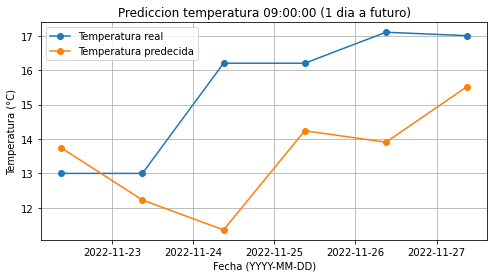

In [31]:
hora = input('Ingresa la hora deseada a predecir: ') #09:00:00, 14:00:00, 21:00:00
rutaArchivo = input('Ingresa el nombre del archivo EMA: ') #data/encb-7.csv

X, Y = obtenerDS(hora, rutaArchivo)
predictions_list = calculaPredicciones(hora, X)
graficar(Y, predictions_list, hora)
print("\n\n********************************************************")
print("La temperatura del día", Y['Hora Local'][0], "será:", predictions_list[0])
print("********************************************************")